In [14]:
!pip install gymnasium
!pip install ale_py

In [2]:
import numpy as np
import gymnasium as gym
import ale_py
import tensorflow as tf
from collections import deque, Counter
import random
from datetime import datetime

In [3]:
color = np.array([210, 164, 74]).mean()

#preprocess (210, 160, 3) uint8 frame into 7040 (88x80) 1D float vector

def preprocess_observation(obs):

    # Crop and resize the image
    img = obs[22:197:2, ::2]

    # Convert the image to greyscale
    img = img.mean(axis=2)

    # Improve image contrast
    img[img==color] = 0

    # Next we normalize the image from -1 to +1
    img = (img - 128) / 128 - 1

    return img.reshape(88,80,1)

5


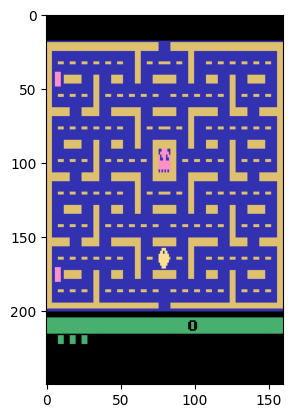

In [4]:
gym.register_envs(ale_py)

env = gym.make("ALE/Pacman-v5")
n_outputs = env.action_space.n
print(n_outputs)
#print(env.get_action_meanings())

observation = env.reset()

import tensorflow as tf
import matplotlib.pyplot as plt


for i in range(22):
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, _, _, _, _ = env.step(1)

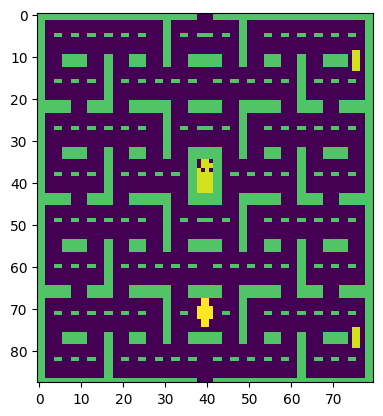

(250, 160, 3)
(88, 80)


In [5]:
#Take a look at the preprocessed inputs in greyscale
#Let's compare the original and preprocessed tensors.

obs_preprocessed = preprocess_observation(observation).reshape(88,80)
plt.imshow(obs_preprocessed)
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)

In [6]:
tf.compat.v1.reset_default_graph() # type: ignore
#Reset is technically not necessary if variables done  in TF2
#https://github.com/ageron/tf2_course/issues/8

def q_network(X, name_scope):

    # Initialize layers
    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0)

    with tf.compat.v1.variable_scope(name_scope) as scope:

        X = tf.cast(X, dtype=tf.float32)
        #X = tf.ensure_shape(X, [None, 11, 10, 64])

        # initialize the convolutional layers
        layer_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(8,8), strides=4, padding='SAME', bias_initializer=initializer, name='conv1')(X)
        tf.compat.v1.summary.histogram('layer_1',layer_1)

        layer_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=2, padding='SAME', bias_initializer=initializer, name='conv2')(layer_1)
        tf.compat.v1.summary.histogram('layer_2',layer_2)

        layer_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='SAME', bias_initializer=initializer, name='conv3')(layer_2)
        tf.compat.v1.summary.histogram('layer_3',layer_3)

        # Flatten the result of layer_3 before feeding to the fully connected layer
        flat = tf.keras.layers.Flatten(name='flatten')(layer_3)
        # Insert fully connected layer
        fc = tf.keras.layers.Dense(units=128, bias_initializer=initializer, name='fc1')(flat)
        tf.compat.v1.summary.histogram('fc',fc)
        #Add final output layer
        output = tf.keras.layers.Dense(units=n_outputs, activation=None, bias_initializer=initializer, name='output')(fc)
        tf.compat.v1.summary.histogram('output',output)


        # Vars will store the parameters of the network such as weights
        vars = {v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)}
        #Return both variables and outputs together
        return vars, output

In [7]:
epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

#
def epsilon_greedy(action, step):
    p = np.random.random(1).squeeze() #1D entries returned using squeeze
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps) #Decaying policy with more steps
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

In [8]:
buffer_len = 20000
#Buffer is made from a deque - double ended queue
exp_buffer = deque(maxlen=buffer_len)

In [9]:
def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    mem = [exp_buffer[i] for i in perm_batch]
    mem = np.array(mem, dtype=object)
    #mem = np.array(exp_buffer)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]

In [10]:
num_episodes = 800
batch_size = 48
input_shape = (None, 88, 80, 1)
#Recall shape is img.reshape(88,80,1)
learning_rate = 0.001
X_shape = (None, 88, 80, 1)
discount_factor = 0.97

global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000

In [11]:
logdir = 'logs'
tf.compat.v1.reset_default_graph()

tf.compat.v1.disable_eager_execution()

# Now we define the placeholder for our input i.e game state
X = tf.compat.v1.placeholder(tf.float32, shape=X_shape)

# we define a boolean called in_training_model to toggle the training
in_training_mode = tf.compat.v1.placeholder(tf.bool)

In [12]:
# we build our Q network, which takes the input X and generates Q values for all the actions in the state
mainQ, mainQ_outputs = q_network(X, 'mainQ')

# similarly we build our target Q network
targetQ, targetQ_outputs = q_network(X, 'targetQ')

In [13]:
# define the placeholder for our action values

X_action = tf.compat.v1.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(input_tensor=targetQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1, keepdims=True)

In [16]:
copy_op = [tf.compat.v1.assign(main_name, targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main = tf.group(*copy_op)

In [17]:
# define a placeholder for our output i.e action
y = tf.compat.v1.placeholder(tf.float32, shape=(None,1))

# now we calculate the loss which is the difference between actual value and predicted value
loss = tf.reduce_mean(input_tensor=tf.square(y - Q_action))

# we use adam optimizer for minimizing the loss
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()

loss_summary = tf.compat.v1.summary.scalar('LOSS', loss)
merge_summary = tf.compat.v1.summary.merge_all()
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())

In [27]:
def live_long_reward(lives):
  return -0.1 + 0.1 * lives

In [28]:
with tf.compat.v1.Session() as sess:
    init.run()

    # for each episode
    history = []
    for i in range(num_episodes):
        done = False
        obs = env.reset()[0]
        lives = 4
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter()
        episodic_loss = []

        # while the state is not the terminal state
        while not done:

           #env.render()

            # get the preprocessed game screen
            obs = preprocess_observation(obs)

            # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER

            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

            # get the action
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1

            # select the action using epsilon greedy policy
            action = epsilon_greedy(action, global_step)

            # now perform the action and move to the next state, next_obs, receive reward
            try:
              next_obs, reward, done, _, data = env.step(action)
            except:
              next_obs, reward, done, _, data = env.step(action[0])

            # CUSTOM REWARD FUNCTION
            reward = live_long_reward(data["lives"])

            # Store this transistion as an experience in the replay buffer! Quite important
            exp_buffer.append([obs, action, preprocess_observation(next_obs), reward, done])

            # After certain steps, we train our Q network with samples from the experience replay buffer
            if global_step % steps_train == 0 and global_step > start_steps:

                # sample experience, mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

                # states
                o_obs = [x for x in o_obs]

                # next states
                o_next_obs = [x for x in o_next_obs]

                # next actions
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})


                # discounted reward: these are our Y-values
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done)

                # merge all summaries and write to the file
                mrg_summary = merge_summary.eval(feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:False})
                file_writer.add_summary(mrg_summary, global_step)

                # To calculate the loss, we run the previously defined functions mentioned while feeding inputs
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                episodic_loss.append(train_loss)

            # after some interval we copy our main Q network weights to target Q network
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()

            obs = next_obs
            epoch += 1
            global_step += 1
            episodic_reward += reward

        history.append(episodic_reward)
        print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history))

Epochs per episode: 568 Episode Reward: 107.3000000000004 Episode number: 1
Epochs per episode: 434 Episode Reward: 75.2999999999996 Episode number: 2
Epochs per episode: 376 Episode Reward: 58.80000000000038 Episode number: 3
Epochs per episode: 406 Episode Reward: 64.9000000000004 Episode number: 4
Epochs per episode: 416 Episode Reward: 76.1999999999998 Episode number: 5
Epochs per episode: 690 Episode Reward: 106.39999999999878 Episode number: 6
Epochs per episode: 412 Episode Reward: 70.90000000000003 Episode number: 7
Epochs per episode: 422 Episode Reward: 60.40000000000044 Episode number: 8


KeyboardInterrupt: 

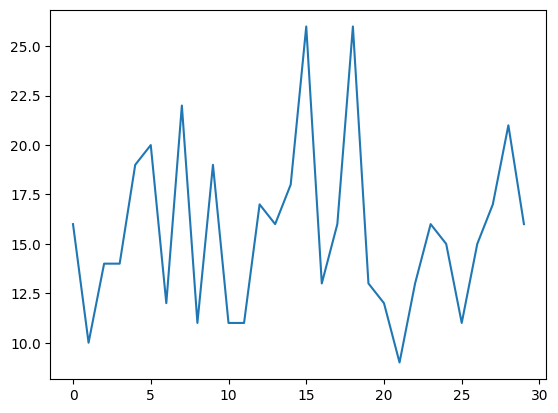

In [18]:
plt.plot(history)
plt.show()

# Video

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

In [ ]:
#To Evaluate model on OpenAI gym, we will record a video via Ipython display



from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
#Evaluate model on openAi GYM
env = wrap_env(gym.make("ALE/Pacman-v5"))
observation = env.reset()
new_observation = observation

prev_input = None
done = False

with tf.compat.v1.Session() as sess:
    init.run()
    while True:
      if True:

        #set input to network to be difference image


        obs = preprocess_observation(observation)

        # feed the game screen and get the Q values for each action
        actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

        # get the action
        action = np.argmax(actions, axis=-1)
        actions_counter[str(action)] += 1

        # select the action using epsilon greedy policy
        action = epsilon_greedy(action, global_step)
        env.render()
        observation = new_observation
        # now perform the action and move to the next state, next_obs, receive reward
        new_observation, reward, done, _ = env.step(action)

        if done:
          #observation = env.reset()
          break

    env.close()
    show_video()